In [27]:
from __future__ import annotations

import os
import glob
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple

import cv2
import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
except Exception:
    %pip -q install matplotlib
    import matplotlib.pyplot as plt

try:
    import pytesseract  # optional
except Exception:
    pytesseract = None

def find_project_root(start: Path | None = None) -> Path:
    cur = (start or Path.cwd()).resolve()
    markers = ['README.md', 'Backend', 'Frontend', 'image']
    for p in [cur, *cur.parents]:
        if all((p / m).exists() for m in markers):
            return p
    return cur

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)

print('PROJECT_ROOT:', PROJECT_ROOT)
print('CWD:', Path.cwd())
print('OpenCV:', cv2.__version__)
print('Tesseract available:', pytesseract is not None)

PROJECT_ROOT: /Users/nguyenhuuthang/Documents/RepoGitHub/Image-Processing-for-Text-Cleaning
CWD: /Users/nguyenhuuthang/Documents/RepoGitHub/Image-Processing-for-Text-Cleaning
OpenCV: 4.12.0
Tesseract available: True


In [28]:
def imread_unicode(path: str | Path) -> np.ndarray:
    p = Path(path)
    if not p.is_absolute():
        p = (PROJECT_ROOT / p).resolve()
    if not p.exists():
        raise FileNotFoundError(f'Không tìm thấy ảnh: {p} (PROJECT_ROOT={PROJECT_ROOT})')
    data = np.fromfile(str(p), dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f'Không đọc được ảnh (decode failed): {p}')
    return img

def to_gray(bgr: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

def show_grid(images: Dict[str, np.ndarray], cols: int = 3, figsize: Tuple[int, int] = (15, 8)):
    names = list(images.keys())
    n = len(names)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=figsize)
    for i, name in enumerate(names, start=1):
        img = images[name]
        plt.subplot(rows, cols, i)
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def binarize(gray: np.ndarray, method: str = 'otsu', adaptive_block: int = 31, adaptive_c: int = 10) -> np.ndarray:
    if method.lower() == 'otsu':
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method.lower() in ('adaptive', 'adaptive_mean', 'adaptive_gaussian'):
        block = adaptive_block if adaptive_block % 2 == 1 else adaptive_block + 1
        adaptive_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C if method.lower() != 'adaptive_mean' else cv2.ADAPTIVE_THRESH_MEAN_C
        th = cv2.adaptiveThreshold(gray, 255, adaptive_type, cv2.THRESH_BINARY, block, adaptive_c)
    else:
        raise ValueError('method phải là otsu hoặc adaptive')
    white_ratio = (th > 0).mean()
    if white_ratio > 0.85:
        th = cv2.bitwise_not(th)
    return th

def morph_open(bin_img: np.ndarray, k: int = 3, iterations: int = 1) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    return cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=iterations)

def morph_close(bin_img: np.ndarray, k: int = 3, iterations: int = 1) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    return cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=iterations)

def background_feature(gray: np.ndarray, mode: str = 'auto', k: int = 25) -> Tuple[str, np.ndarray]:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    chosen = mode.lower()
    if chosen == 'auto':
        chosen = 'blackhat' if float(gray.mean()) > 127.0 else 'tophat'
    if chosen == 'blackhat':
        feat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    elif chosen == 'tophat':
        feat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    elif chosen in ('none', 'off'):
        feat = np.zeros_like(gray)
    else:
        raise ValueError('mode phải là auto|blackhat|tophat|none')
    return chosen, feat

def enhance_with_feature(gray: np.ndarray, feat: np.ndarray, mode: str) -> np.ndarray:
    if mode == 'blackhat':
        enhanced = cv2.subtract(gray, feat)
    elif mode == 'tophat':
        enhanced = cv2.add(gray, feat)
    else:
        enhanced = gray
    return cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)

@dataclass
class PipelineParams:
    threshold: str = 'otsu'
    adaptive_block: int = 31
    adaptive_c: int = 10
    open_k: int = 3
    open_iter: int = 1
    close_k: int = 3
    close_iter: int = 1
    bg_mode: str = 'auto'
    bg_kernel: int = 25

def run_pipeline(bgr: np.ndarray, p: PipelineParams) -> Dict[str, np.ndarray]:
    out: Dict[str, np.ndarray] = {}
    out['original'] = bgr
    gray = to_gray(bgr)
    out['gray'] = gray
    chosen_mode, feat = background_feature(gray, mode=p.bg_mode, k=p.bg_kernel)
    out[f'bg_feature_{chosen_mode}'] = feat
    gray_enh = enhance_with_feature(gray, feat, chosen_mode) if chosen_mode not in ('none', 'off') else gray
    out['gray_enhanced'] = gray_enh
    th = binarize(gray_enh, method=p.threshold, adaptive_block=p.adaptive_block, adaptive_c=p.adaptive_c)
    out[f'binary_{p.threshold}'] = th
    opened = morph_open(th, k=p.open_k, iterations=p.open_iter)
    out[f'opening_k{p.open_k}'] = opened
    closed = morph_close(opened, k=p.close_k, iterations=p.close_iter)
    out[f'closing_k{p.close_k}'] = closed
    out['final'] = closed
    return out

Using image: /Users/nguyenhuuthang/Documents/RepoGitHub/Image-Processing-for-Text-Cleaning/image/test-image/test-3.png


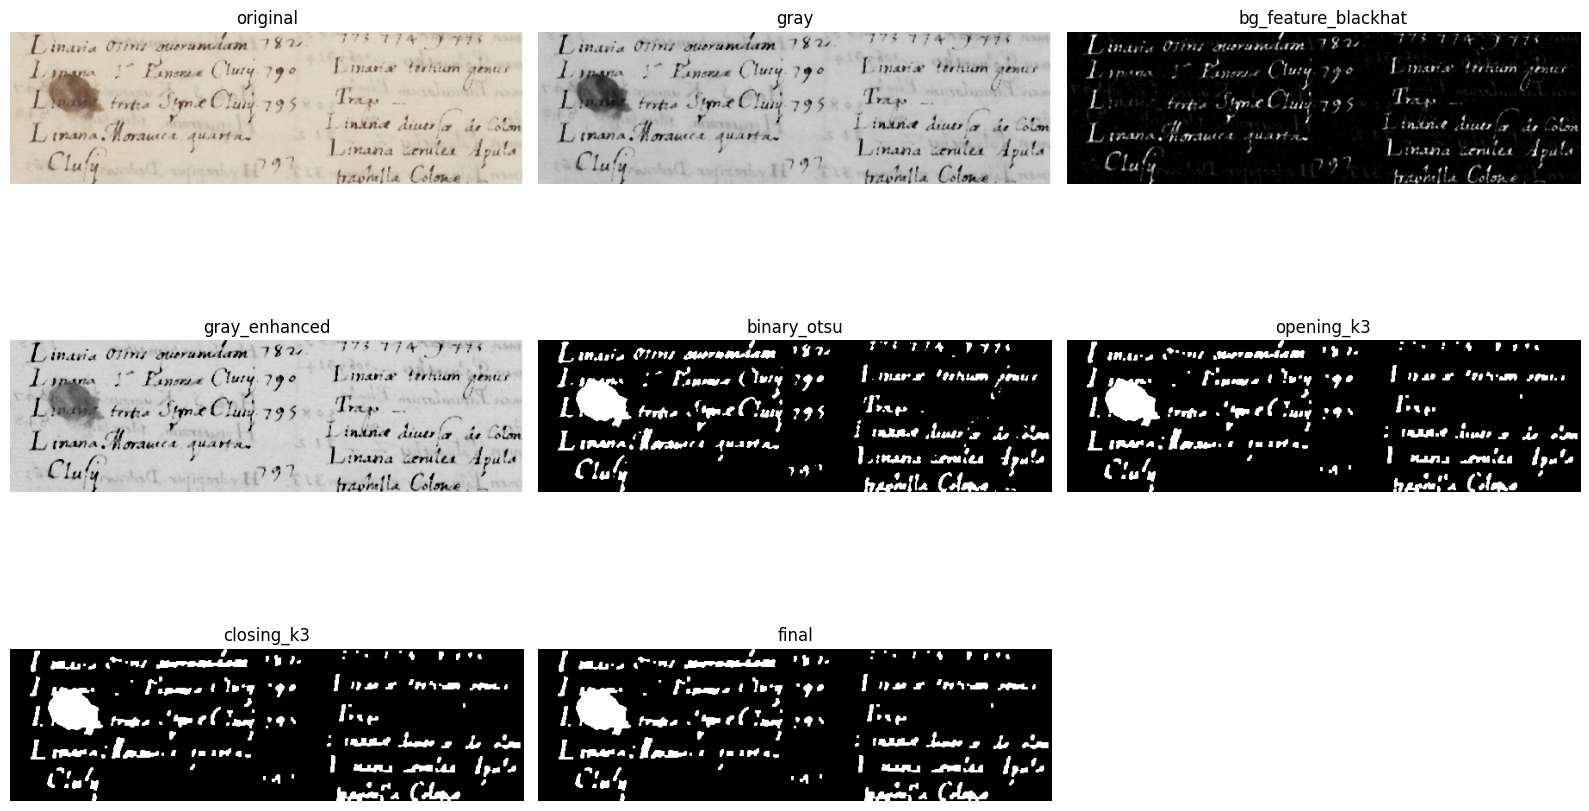

In [29]:
# # Chạy thử 1 ảnh (auto pick)
# search_dirs = [PROJECT_ROOT / 'image/test-image', PROJECT_ROOT / 'image/original', PROJECT_ROOT / 'image/final-test']
# paths = []
# for d in search_dirs:
#     if d.exists():
#         for ext in ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff'):
#             paths += sorted(d.glob(ext))
#     if paths:
#         break
# if not paths:
#     raise FileNotFoundError(f'Không tìm thấy ảnh trong: {search_dirs}')

# img_path = paths[0]
# print('Using image:', img_path)
# bgr = imread_unicode(img_path)

# params = PipelineParams(threshold='otsu', open_k=3, close_k=3, bg_mode='auto', bg_kernel=25)
# stages = run_pipeline(bgr, params)
# show_grid(stages, cols=3, figsize=(16, 10))


# Chạy thử 1 ảnh (đổi path nếu bạn muốn)
img_name = 'test-3.png'

# 1) Nếu cell batch (index 3) đã chạy, biến `paths` đã có sẵn => tìm đúng ảnh theo tên
candidate = None
if 'paths' in globals() and isinstance(paths, list):
    candidate = next((p for p in paths if Path(p).name == img_name), None)

# 2) Nếu chưa có `paths` hoặc không tìm thấy, thử các thư mục phổ biến trong repo
if candidate is not None:
    img_path = candidate
else:
    search_dirs = [
        PROJECT_ROOT,
        PROJECT_ROOT / 'image/test-image',
        PROJECT_ROOT / 'image/original',
        PROJECT_ROOT / 'image/final-test',
    ]
    for d in search_dirs:
        p = d / img_name
        if p.exists():
            img_path = p
            break
    else:
        raise FileNotFoundError(f'Không tìm thấy ảnh: {img_name} trong {search_dirs}')

print('Using image:', img_path)

bgr = imread_unicode(img_path)

# Denoise nhẹ (không cần sửa PipelineParams/run_pipeline)
bgr = cv2.medianBlur(bgr, 3)

params = PipelineParams(
    threshold='otsu',      # 'otsu' hoặc 'adaptive'
    open_k=3, open_iter=1,
    close_k=3, close_iter=1,
    bg_mode='auto',        # 'auto'|'blackhat'|'tophat'|'none'
    bg_kernel=5,           # kernel lớn hơn => ít nhạy với vết bẩn nhỏ
)

stages = run_pipeline(bgr, params)
show_grid(stages, cols=3, figsize=(16, 10))


In [30]:
# Batch: xử lý cả thư mục và lưu kết quả
in_dir = PROJECT_ROOT / 'image/test-image'  # đổi sang PROJECT_ROOT / 'image/original' nếu muốn
out_root = PROJECT_ROOT / 'notebook_output'
run_id = time.strftime('%Y%m%d_%H%M%S')
out_dir = out_root / run_id
out_dir.mkdir(parents=True, exist_ok=True)

paths = []
for ext in ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff'):
    paths += sorted(in_dir.glob(ext))

rows = []
for pth in paths:
    bgr_i = imread_unicode(pth)
    stages = run_pipeline(bgr_i, PipelineParams())
    out_path = out_dir / f'{pth.stem}_final.png'
    cv2.imwrite(str(out_path), stages['final'])
    rows.append({'file': pth.name, 'fg_ratio': float((stages['final'] > 0).mean())})

summary = pd.DataFrame(rows).sort_values('file') if rows else pd.DataFrame(columns=['file','fg_ratio'])
summary.to_csv(out_dir / 'metrics.csv', index=False)
print('Saved outputs to:', out_dir)
summary.head(10)

Saved outputs to: /Users/nguyenhuuthang/Documents/RepoGitHub/Image-Processing-for-Text-Cleaning/notebook_output/20251218_110253


,file,fg_ratio
6,H01.bmp,0.068475
7,H02.bmp,0.086568
8,H03.bmp,0.144766
9,H04.bmp,0.723480
10,H05.bmp,0.779567
0,test-1.png,0.144999
1,test-2.png,0.725569
2,test-3.png,0.839215
3,test-4.png,0.111675
4,test-5.jpg,0.800005
